<a href="https://colab.research.google.com/github/almazav/Masters-Project/blob/main/Graph_Representation_Turth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Representation
The Aim of thi notebook is to understand how to reresent the data in a graph form. We will use the truth data and initially use only the hit id, z position and radius as features, in the future other features can be included like the chanels and signal.

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

# def format_pytorch_version(version):
#   return version.split('+')[0]

# TORCH_version = torch.__version__
# TORCH = format_pytorch_version(TORCH_version)

# def format_cuda_version(version):
#   return 'cu' + version.replace('.', '')

# CUDA_version = torch.version.cuda
# CUDA = format_cuda_version(CUDA_version)

# !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-geometric 
from torch_geometric.data import Data
import networkx as nx
from torch_geometric.utils.convert import to_networkx
import itertools

In [37]:
#plot parameters
FIGSIZE = (14,7)
FIG_TITLE = 22
FIG_AXIS = 14
FIG_LEGEND = 12

In [99]:
#read the data choose one random event
rand_ev = np.random.randint(0,99,1)
if len(str(rand_ev[0])) > 1:
  event = f'/content/drive/MyDrive/train_100_events/event0000010{str(rand_ev[0])}-truth.csv'
else:
  event = f'/content/drive/MyDrive/train_100_events/event00000100{str(rand_ev[0])}-truth.csv'
df = pd.read_csv(event)
df['radius'] = np.sqrt(df.tx**2 + df.ty**2)
df.head()

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,radius
0,1,265716363744509952,-59.9841,-9.210950,-1502.5,-0.397194,-0.082815,-10.0659,0.000010,60.687180
1,2,598991257385041920,-61.2617,-11.219300,-1502.5,-1.490010,-0.256654,-36.2675,0.000026,62.280563
2,3,598991188665565184,-80.1521,-5.046720,-1502.5,-0.940408,-0.083245,-17.7470,0.000014,80.310824
3,4,202681362124111872,-58.4338,-3.863230,-1502.5,-0.530836,-0.049218,-13.9756,0.000011,58.561365
4,5,684551953723686912,-60.4472,-0.548542,-1502.5,-0.441298,-0.025642,-11.1053,0.000011,60.449689


The truth paths are related to particle id, and lets assume that the hits id are in sequential order, therefore the directed graph will be the sequential order of the hits id as nodes with the edjes between the hits id's

In [100]:
#check how may tracks(particle_id) we have 
unique_tracks = df.particle_id.unique()
print(f'In the event number {str(rand_ev[0])} we have {len(unique_tracks)} tracks')

In the event number 77 we have 8032 tracks


In [101]:
# lets choose some random events 
num_tracks = 10
rand_tracks = np.random.randint(0, len(unique_tracks), num_tracks)
tracks = unique_tracks[rand_tracks]


In [123]:
# visualize one track 
one_track = df.loc[df.particle_id==tracks[3]]
one_track

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,radius
760,761,450361818162921472,137.1840,83.6704,-1498.000,0.633166,0.338996,-6.71914,0.000009,160.686607
2142,2143,450361818162921472,118.3670,73.4494,-1298.000,0.630134,0.350074,-6.71948,0.000007,139.303844
2153,2154,450361818162921472,118.7420,73.6571,-1302.000,0.630188,0.347536,-6.71902,0.000007,139.731997
3790,3791,450361818162921472,99.6816,62.8859,-1098.000,0.626026,0.359785,-6.72028,0.000008,117.860332
3798,3799,450361818162921472,100.0540,63.0998,-1102.000,0.625430,0.359434,-6.71946,0.000007,118.289423
7890,7891,450361818162921472,73.7162,47.6075,-817.500,0.619390,0.371370,-6.72131,0.000011,87.752790
10286,10287,450361818162921472,62.6864,40.9446,-697.500,0.615195,0.377954,-6.72211,0.000013,74.873527
12718,12719,450361818162921472,53.5568,35.2800,-597.500,0.612875,0.382594,-6.72265,0.000019,64.132747
12789,12790,450361818162921472,54.0124,35.5647,-602.500,0.612272,0.383168,-6.72212,0.000016,64.669833
13854,13855,450361818162921472,26.6950,18.0513,-300.369,0.605019,0.396993,-6.72355,0.000023,32.225339


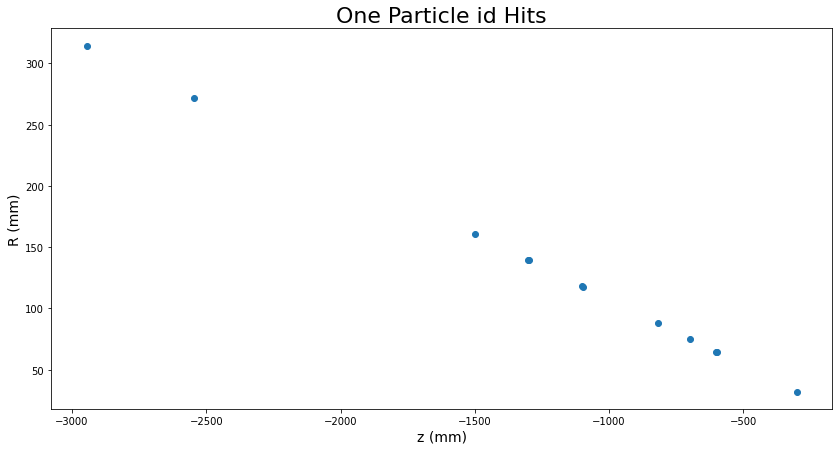

In [124]:
#plot
fig, ax = plt.subplots(figsize = FIGSIZE)
ax.scatter(one_track.tz,one_track.radius)
ax.set_title('One Particle id Hits', fontsize = FIG_TITLE)
ax.set_xlabel('z (mm)', fontsize = FIG_AXIS)
ax.set_ylabel('R (mm)', fontsize = FIG_AXIS)
plt.show()

In [125]:
# make an edge list from the one particle example 
# get hits_ids
new_id = np.arange(0,len(one_track))   #just for ploting 
one_track['new_id'] = new_id
hits_ids = one_track.hit_id.values
edge_list = torch.tensor([
                          new_id[:-1],     #source nodes
                          new_id[1:]      #target nodes
                          ],dtype=torch.long)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [126]:
#create a list with the position node features for the given particle id 
node_feature_list =[]
for i in range(len(one_track)):
  node_feature_list.append(one_track.loc[one_track.hit_id==hits_ids[i]][['tx','ty','tz','radius']].values[0].tolist())

#create a node feature tensor with the node_feature_list info 
node_features = torch.tensor(node_feature_list,dtype=torch.long)


In [127]:
#make a data object to store graph information 
data = Data(x = node_features,edge_index=edge_list)

In [128]:
#print graph info 
print(f"""Number of nodes: {data.num_nodes},
Number of edges: {data.num_edges},
Number of features per node: {data.num_node_features}""")

Number of nodes: 12,
Number of edges: 11,
Number of features per node: 4


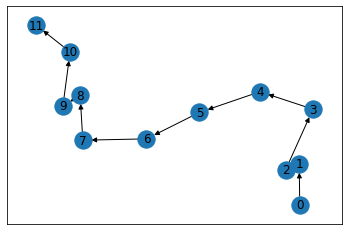

In [129]:
#plot the graph
G.remove_node(0)
G = to_networkx(data)
nx.draw_networkx(G)

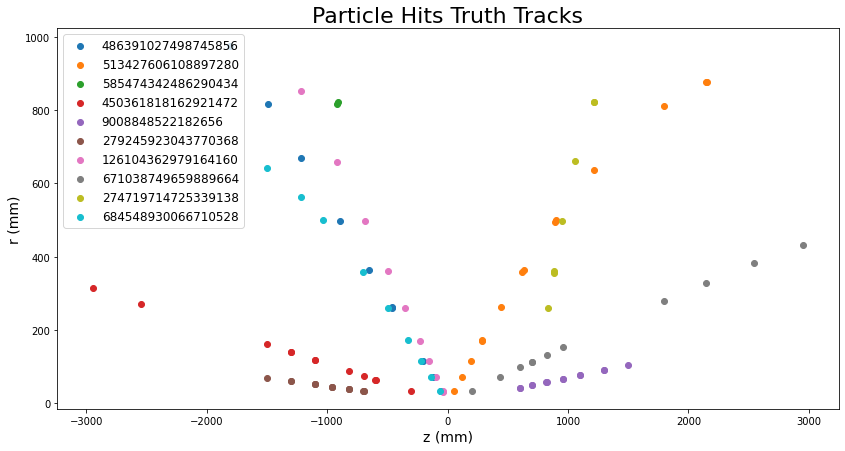

In [108]:
#now for the randomly selected 
#make a scatter plot 
fig, ax = plt.subplots(figsize = FIGSIZE)
for track in tracks:
  ax.scatter(df.loc[df.particle_id==track].tz, df.loc[df.particle_id==track].radius, label=f'{track}')
ax.set_title('Particle Hits Truth Tracks', fontsize= FIG_TITLE)
ax.set_xlabel('z (mm)', fontsize=FIG_AXIS)
ax.set_ylabel('r (mm)', fontsize = FIG_AXIS)
ax.legend(fontsize = FIG_LEGEND)
plt.show()

In [117]:
#create a df with the selected particles
df_some_tracks = df[df.particle_id.isin(tracks)]
# get hits_ids just because we are not getting random particles in a real scenario the hits will allways start from zero
new_id = np.arange(0,len(df_some_tracks))  
df_some_tracks['new_id'] = new_id


In [143]:
#create the edges between nodes
#edges are directed
source_nodes = []     
target_nodes = []
for track in tracks:
  nodes = df_some_tracks.loc[df.particle_id==track].new_id.values.tolist()
  source_nodes.append(nodes[:-1])      #the last node is not conected to anything 
  target_nodes.append(nodes[1:])

source_nodes = list(itertools.chain(*source_nodes))
target_nodes = list(itertools.chain(*target_nodes))


In [144]:
edge_list = torch.tensor([
                          source_nodes,     #source nodes
                          target_nodes     #target nodes
                          ],dtype=torch.long)

In [152]:
#create node features
#create a list with the position node features for the given particle id 
node_feature_list =[]
for track in tracks:
  temp_df = df_some_tracks.loc[df_some_tracks.particle_id==track]
  ids = temp_df.new_id.values
  for id in ids:
    node_feature_list.append(temp_df.loc[temp_df.new_id==id][['tx','ty','tz','radius']].values[0].tolist())

In [153]:
#create a node feature tensor with the node_feature_list info 
node_features = torch.tensor(node_feature_list,dtype=torch.long)

In [155]:
#make a data object to store graph information 
data = Data(x = node_features,edge_index=edge_list)

In [156]:
#print graph info 
print(f"""Number of nodes: {data.num_nodes},
Number of edges: {data.num_edges},
Number of features per node: {data.num_node_features}""")

Number of nodes: 104,
Number of edges: 94,
Number of features per node: 4


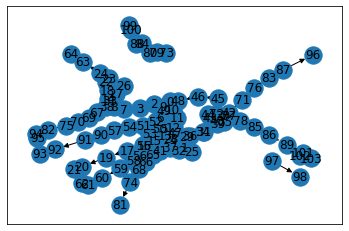

In [157]:
#plot the graph
G.remove_node(0)
G = to_networkx(data)
nx.draw_networkx(G)

In [159]:
df_some_tracks.loc[df_some_tracks.particle_id==585474342486290434]


,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,radius,new_id
84973,84974,585474342486290434,-750.875,334.484,-912.883,-0.068506,0.136812,0.069793,0.0,822.005360,97
84977,84978,585474342486290434,-747.426,327.766,-916.253,-0.072345,0.135954,0.068753,0.0,816.134901,98
